# Code for generating Fig. 7

## Imports

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from alphashape import alphashape
from matplotlib.collections import LineCollection
import torch
from torch import nn
import json
from sklearn.model_selection import GroupShuffleSplit
from shapely.geometry import Point

#Getting the full manifold data
df = pd.read_csv('no_avg_dataset.csv')

#Getting the alpha shape
z_array = np.concatenate((np.asarray(df["Z0"]).reshape(-1,1), np.asarray(df["Z1"]).reshape(-1,1)), axis = 1)
alpha_shape = alphashape(z_array, alpha = 1)

seqs = np.unique(df["Sequence"])
ps = np.unique(df["p"])

## Alpha shape code and NN class 

In [2]:
def plot_alpha_shape(alpha_shape, ax = None):
    if ax is None:
        plt.plot(*alpha_shape.exterior.xy, color='black', linewidth=1, label='Alpha Shape')
        
    else:
        ax.plot(*alpha_shape.exterior.xy, color='black', linewidth=1, label='Alpha Shape')

In [9]:
#Always run

class MLPRegressor(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=(100, ), activation=nn.ReLU()):
        torch.manual_seed(0)  # control random effects

        super(MLPRegressor, self).__init__()

        layers = []
        prev_layer_size = input_size
        for layer_size in hidden_size:
            layers.append(nn.Linear(prev_layer_size, layer_size))
            layers.append(activation)
            prev_layer_size = layer_size

        layers.append(nn.Linear(prev_layer_size, output_size))
        self.fc_layers = nn.Sequential(*layers)

    def forward(self, x):
        #x = x.clone().detach().requires_grad_(True)
        x = self.fc_layers(x)
        return x
    

# create a data structure to convert from str input to nn function
activation_dict = {'tanh': nn.Tanh(),
                   'relu': nn.ReLU(),
                   'leaky_relu': nn.LeakyReLU(),
                   'sigmoid': nn.Sigmoid(),
                   'elu': nn.ELU()}

def generate_model_and_optimizer(params):
    # create a list of layer sizes from the start, end, and depth
    raw_dims = np.linspace(params["layer_i"], params["layer_f"], params["num_layers"])
    hidden_size = tuple(raw_dims.round().astype(int))
    # choose the activation function
    activation = activation_dict[params['activation']]

    # initialize the model
    model = MLPRegressor(3, 2, hidden_size, activation)

    # initialize the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])

    # return both objects to calling function
    return model, optimizer

## Importing model

In [10]:
# Loading absolute model
with open('best_parameters_absolute.json', 'r') as f:
    best_parameters = json.load(f)

#Initializing the model (maybe not the right wording here)
model_absolute, optimizer = generate_model_and_optimizer(best_parameters)
model_dict = torch.load('embedding_model_noavg_absolute.pth')

#Loading pre-saved weights to the model
model_absolute.load_state_dict(model_dict)

<All keys matched successfully>

## Getting edge points

In [6]:
#To get the points along the edge of the shape

# To get points slightly inside the boundary 
shrink_dist = -0.25
sh_alpha_shape = alpha_shape.buffer(shrink_dist)

# Extract the boundary of the alpha shape
boundary = sh_alpha_shape.boundary

# Convert the boundary to a list of (x, y) coordinates
boundary_coords = list(boundary.coords)

# Convert the boundary coordinates to a NumPy array
boundary_coords = np.array(boundary_coords)

# Define desired arc length interval for sampling
desired_interval = 0.75  # Adjust as needed

# Sample points along the boundary at the desired interval
sampled_points = []
total_length = boundary.length
current_length = 0
while current_length < total_length:
    point = boundary.interpolate(current_length)
    x, y = point.x, point.y

    # Compute the projection of the point onto the boundary
    projected_point = sh_alpha_shape.exterior.interpolate(sh_alpha_shape.exterior.project(Point(x, y)))
    
    x_inside, y_inside = projected_point.x, projected_point.y
    sampled_points.append((x_inside, y_inside))
    
    current_length += desired_interval

# Convert sampled points to a NumPy array
edge_sampled_points = np.array(sampled_points)


## Plotting

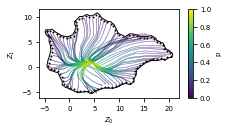

In [7]:
# Fig specs
fig_width_in = 8.3 /2.54 
aspect_ratio = 2
fig_height_in = fig_width_in / aspect_ratio
fontsize = 7

# Defining figure
fig, ax = plt.subplots(figsize = (fig_width_in, fig_height_in))

# Getting alpha shape
z_array = np.concatenate((np.asarray(df["Z0"]).reshape(-1,1), np.asarray(df["Z1"]).reshape(-1,1)), axis = 1)
alpha_shape = alphashape(z_array, alpha = 1)
plt.plot(*alpha_shape.exterior.xy, color='black', linewidth=1, label='Alpha Shape')

# Lists to save points and segments
linesegments = []
pointlist = []
points_in_mfld = []
ps = np.arange(0,1.001,0.001)

# Go through each edge point
for point in edge_sampled_points:
    points_in_mfld.append(point)
    point_predict_list = []

    # Find the predicted coordinate for each starting edge point and p value
    for p in ps:
        #Reset temporary coordinate
        tempcoord = list(point)
        #Add p value
        tempcoord.append(p)
        output = model_absolute(torch.Tensor(tempcoord))
        point_predict_list.append(output.detach().numpy())
    
    # Making line segment for each pair of predicted points
    cols = ps
    point_path = np.vstack(point_predict_list)
    xm = np.asarray(point_path[:,0])
    ym = np.asarray(point_path[:,1])
    points = np.array([xm, ym]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Turning line segments into LineCollection colored by p
    pointlist.append(points)
    lc = LineCollection(segments, cmap='viridis')
    linesegments.append(lc.get_segments())
    lc.set_array(cols)
    lc.set_linewidth(0.5)
    line = ax.add_collection(lc)

# Plotting
plt.scatter(edge_sampled_points[:,0], edge_sampled_points[:,1], c = 'k', s = 1)
cbar = fig.colorbar(line,ax=ax)
cbar.set_label("p", fontsize = fontsize)
cbar.ax.tick_params(labelsize=fontsize) 
ax.set_xlabel(r'$Z_0$', fontsize = fontsize)
ax.set_ylabel(r'$Z_1$', fontsize = fontsize)
ax.tick_params(axis = 'x', labelsize = fontsize)
ax.tick_params(axis = 'y', labelsize = fontsize)
ax.set_aspect('equal')
plt.show() 

### Save figure

In [20]:
fig.savefig('traj_from_edges_fig_7.pdf', dpi = 600, bbox_inches = 'tight')